In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2
from google.colab.patches import cv2_imshow

In [2]:
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [3]:
def map_char(char):
  dict_char = {
      '0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,
      'A':10,  'B':11, 'C':12, 'D':13, 'E':14, 'F':15, 'G':16, 'H':17, 'I':18 ,'J':19, 'K':20, 
      'L':21, 'M':22, 'N':23, 'O':24, 'P':25, 'Q':26, 'R':27, 'S':28, 'T':29, 'U':30, 
      'V':31, 'W':32, 'X':33, 'Y':34, 'Z':35
  }
  return dict_char[char]
def map_char_class(char):
  dict_char = {
      0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',
      10:'A',  11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I' ,19:'J', 20:'K', 
      21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T', 30:'U', 
      31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z'
  }
  return dict_char[char]

In [ ]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [ ]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate # returning the processed image.

def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def convert_y(num):
  arr = [0] * 36
  arr[num]=1
  return np.array(arr)
convert_y(3)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:


lst_class =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
path_train = '/content/drive/My Drive/Data/bien-so-xe/cnn/train'
path_val = '/content/drive/My Drive/Data/bien-so-xe/cnn/val'
def get_data_X_y(path_train):
  X_test = []
  y_test = []
  for c in lst_class:
      path_class = os.path.join(path_train,str(c))   
      # print(path_class) 
      for filename in os.listdir(path_class):
        path = os.path.join(path_class,filename) 
        img = cv2.imread(path)
        img = cv2.resize(img, (64,64), interpolation=cv2.INTER_AREA)
        img = img/255.0
        X_test.append(img)
        y_test.append(c)
  return X_test,y_test
  
X_val, y_val = get_data_X_y(path_val)
X_train,y_train = get_data_X_y(path_train)

X_train=np.array(X_train)
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val=np.array(y_val)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [ ]:
len(y_train)

70

In [ ]:
# import tensorflow.keras.backend as K
# train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1,rotation_range = 5)
# # path = '../input/ai-indian-license-plate-recognition-data/data/data'
# path = '/content/drive/My Drive/Data/bien-so-xe/cnn'
# train_generator = train_datagen.flow_from_directory(
#         path+'/train',  # this is the target directory
#         target_size=(64,64),  # all images will be resized to 28x28
#         batch_size=1,
#         class_mode='sparse')

# validation_generator = train_datagen.flow_from_directory(
#         path+'/val',  # this is the target directory
#         target_size=(64,64),  # all images will be resized to 28x28 batch_size=1,
#         class_mode='sparse')

In [ ]:
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (5,5), input_shape=(64, 64, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (5,5), input_shape=(64, 64, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (5,5), input_shape=(64, 64, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (5,5), input_shape=(64, 64, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                        

In [ ]:

# from keras.applications.inception_v3 import InceptionV3
# from keras.preprocessing import image
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten,BatchNormalization
# from tensorflow.keras.optimizers import Adam # - Does not work

# base_model = InceptionV3(input_shape=(299,299,3),include_top=False,weights='imagenet')
# #279 is number of mixed 9 layer
# #248 is number of mixed 8 layer

# for layer in base_model.layers[:172]:
#     layer.trainable = False

# x = base_model.output
# x=Flatten()(x)
# x = Dropout(0.4)(x)
# x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dense(36,activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=x)

# #a=adam(lr=0.0001)
# model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['acc'])
# batch_size = 3
# history = model.fit_generator(
#       train_generator,
#       steps_per_epoch = train_generator.samples // batch_size,
#       validation_data = validation_generator, 
#       epochs = 5, verbose=1)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy']) #custom_f1score

In [ ]:

history = model.fit(X_train,y_train ,
          batch_size=3,
          epochs=10,
          verbose=1,
          validation_data=(X_val,y_val)
          
          )
     

Epoch 1/10
1105/1105 [==============================] - 13s 10ms/step - loss: 0.7649 - accuracy: 0.8171 - val_loss: 0.2898 - val_accuracy: 0.9173
Epoch 2/10
1105/1105 [==============================] - 10s 9ms/step - loss: 0.2164 - accuracy: 0.9529 - val_loss: 0.1502 - val_accuracy: 0.9610
Epoch 3/10
1105/1105 [==============================] - 10s 9ms/step - loss: 0.1190 - accuracy: 0.9692 - val_loss: 0.2435 - val_accuracy: 0.9539
Epoch 4/10
1105/1105 [==============================] - 10s 9ms/step - loss: 0.1107 - accuracy: 0.9686 - val_loss: 0.1329 - val_accuracy: 0.9682
Epoch 5/10
1105/1105 [==============================] - 10s 9ms/step - loss: 0.0807 - accuracy: 0.9765 - val_loss: 0.2073 - val_accuracy: 0.9515
Epoch 6/10
1105/1105 [==============================] - 10s 9ms/step - loss: 0.0580 - accuracy: 0.9822 - val_loss: 0.2302 - val_accuracy: 0.9452
Epoch 7/10
1105/1105 [==============================] - 10s 9ms/step - loss: 0.0461 - accuracy: 0.9867 - val_loss: 0.2518 - val_a

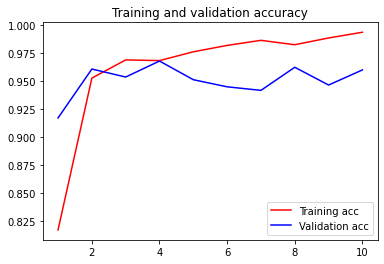

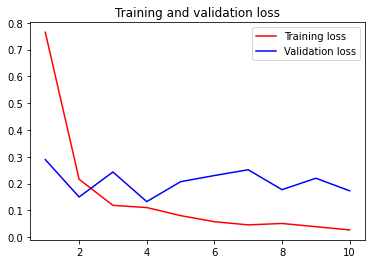

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
# batch_size = 3
# callbacks = [stop_training_callback()]
# model.fit_generator(
#       train_generator,
#       steps_per_epoch = train_generator.samples // batch_size,
#       validation_data = validation_generator, 
#       epochs = 20, verbose=1)

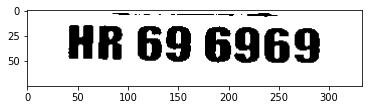

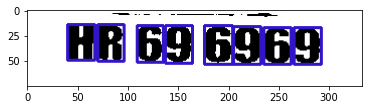

In [ ]:
path_img='/content/drive/My Drive/Data/bien-so-xe/img_cnn/train/car-wbs-HR696969_00000.jpeg'
img = cv2.imread(path_img)
char = segment_characters(img)
# char

In [ ]:
# cv2_imshow(char[0])
img_ = cv2.resize(char[0], (64,64), interpolation=cv2.INTER_AREA)
img = fix_dimension(img_)

img = img.reshape(1,64,64,3) #preparing image for the model

y_ = model.predict(img)[0]
y_

1/1 [==============================] - 0s 22ms/step


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [ ]:
model.predict(img)

1/1 [==============================] - 0s 38ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

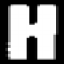

1/1 [==============================] - 0s 21ms/step
H


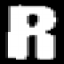

1/1 [==============================] - 0s 18ms/step
B


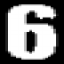

1/1 [==============================] - 0s 22ms/step
6


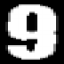

1/1 [==============================] - 0s 24ms/step
9


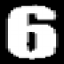

1/1 [==============================] - 0s 18ms/step
6


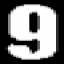

1/1 [==============================] - 0s 19ms/step
9


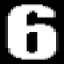

1/1 [==============================] - 0s 20ms/step
6


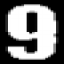

1/1 [==============================] - 0s 25ms/step
9
HB696969


In [ ]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((64,64,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (64,64), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        cv2_imshow(img)
        img = img.reshape(1,64,64,3) #preparing image for the model
        y_ = model.predict(img)[0] #predicting the class
        y_=np.argmax(y_)

        character = map_char_class(y_) #
        print(character)
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

In [ ]:
# ML05H1958

In [ ]:
#9CBZ91BBC
path_lbl='/content/drive/My Drive/Data/bien-so-xe/lbl_cnn/train/ML13.txt'
with open(path_lbl) as f:
      lines = f.readlines()
print(lines)

['ML05H1958']


IndexError: ignored

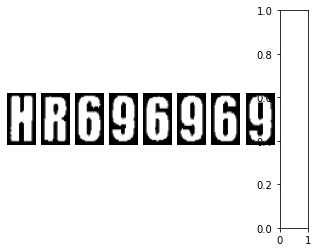

In [ ]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [ ]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [ ]:
plate_number = show_results()
output_img, plate = detect_plate(img, plate_number)
display(output_img, 'detected license plate number in the input image')

In [ ]:
from tensorflow.keras.models import save_model
save_model(model, "model_cnn.h5")

In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
 
# load model
model = load_model('model_cnn.h5')
# summarize model.